WIP classifier for "imagenet_RDAE_batched_250k" batched dataset.

The dataset is derived from the original imagenet dataset using the following procedure

1. Identify the most common image sizes in the dataset
2. Group common sized images into batches of 64
3. Compress each batch of images using a pretrained rate-distortion autoencoder, consisting of a lossy analysis transform and lossless entropy coding.
4. Store the compressed batches of images and their labels.

To train the classifier, only the lossless entropy decoding stage is used. The classifier is trained on the 128 by width/8 by height/8 codes produced by the analysis transform.

In [1]:
import zlib
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as disp
from datasets import load_dataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
def entropy_decoder(compressed_img,original_shape):
    decompressed = zlib.decompress(compressed_img)
    ẑ = np.frombuffer(decompressed, dtype=np.int8)
    ẑ = ẑ.reshape(original_shape)
    return ẑ
    
def batch_entropy_decode(compressed_batch,original_size):
    z = torch.cat([
        torch.tensor(
            entropy_decoder(compressed_batch[i], original_size)
        ) 
        for i in range(batch_size)
    ])
    return z

def live_plot(x):
    plt.clf()
    plt.plot(np.log(x))
    disp.display(plt.gcf())
    disp.clear_output(wait=True)

In [3]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        
        self.conv1 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(1024, 2048, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(2048, 4096, kernel_size=3, stride=2, padding=1)
        self.conv6 = nn.Conv2d(4096, 8192, kernel_size=3, stride=2, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # adaptive pooling to 1x1
        self.conv7 = nn.Conv2d(8192, 16384, kernel_size=1)  # kernel size 1 to maintain 1x1 size
        self.conv8 = nn.Conv2d(16384, 1001, kernel_size=1)  # kernel size 1 to maintain 1x1 size

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool(x)  # apply adaptive pooling
        x = F.relu(self.conv7(x))
        x = self.conv8(x)  # no activation on the last layer
        return x

In [4]:
train_dataset = load_dataset("danjacobellis/imagenet_RDAE_batched_250k",split='train').with_format("torch")
test_dataset = load_dataset("danjacobellis/imagenet_RDAE_batched_250k",split='test').with_format("torch")
N_classes=1001;
net = FCN().to("cuda")
parameters = set(p for n, p in net.named_parameters())
optimizer = optim.Adam(parameters, lr=1e-4)
loss_fn = nn.CrossEntropyLoss()


KeyboardInterrupt



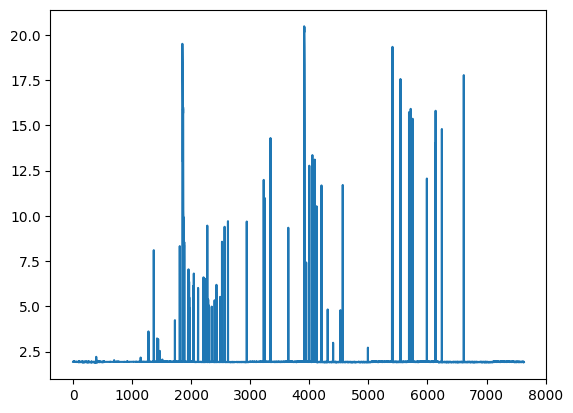

In [5]:
train_loss = np.array([])
test_loss = np.array([])
for i in range(5):
    #train
    for (i_batch, batch) in enumerate(train_dataset):
        latent_size = batch['latent_size']
        batch_size = latent_size[0];
        original_size = latent_size.numpy().copy();
        original_size[0] = 1;
        
        compressed_batch = batch['compressed_batch']
        z = batch_entropy_decode(compressed_batch,original_size);
        z = z.to("cuda").to(torch.float)
        
        label = batch['label'].to(torch.int64)
        y = torch.zeros((batch_size,N_classes,1,1),dtype=torch.int16)
        y.scatter_(1, label.view(-1, 1, 1, 1), 1)
        y = y.to("cuda").to(torch.float)
    
        out = net(z)
        out = out.squeeze(-1).squeeze(-1)
        y = y.squeeze(-1).squeeze(-1)
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(out, y.float()) 
        loss.backward()
        optimizer.step()

        train_loss = np.append(train_loss,loss.detach().cpu().numpy())
    
        torch.save({
                'epoch': i,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
            }, f"classifier_checkpoint.pth")
        live_plot(train_loss)
        
        z.detach()
        y.detach()
    # test
    for (i_batch, batch) in enumerate(test_dataset):
        latent_size = batch['latent_size']
        batch_size = latent_size[0];
        original_size = latent_size.numpy().copy();
        original_size[0] = 1;
        
        compressed_batch = batch['compressed_batch']
        z = batch_entropy_decode(compressed_batch,original_size);
        z = z.to("cuda").to(torch.float)
        
        label = batch['label'].to(torch.int64)
        y = torch.zeros((batch_size,N_classes,1,1),dtype=torch.int16)
        y.scatter_(1, label.view(-1, 1, 1, 1), 1)
        y = y.to("cuda").to(torch.float)
    
        out = net(z)
        out = out.squeeze(-1).squeeze(-1)
        y = y.squeeze(-1).squeeze(-1)
        
        loss = loss_fn(out, y.float()) 

        test_loss = np.append(test_loss,loss.detach().cpu().numpy())
        
        z.detach()
        y.detach()

(1.9, 2.0)

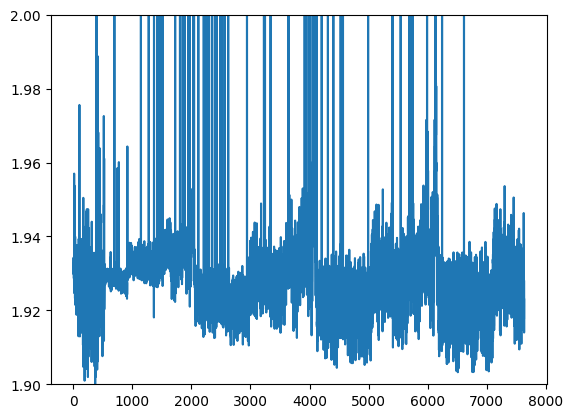

In [16]:
plt.plot(np.log(train_loss))
plt.ylim([1.9,2])

(1.9, 2.0)

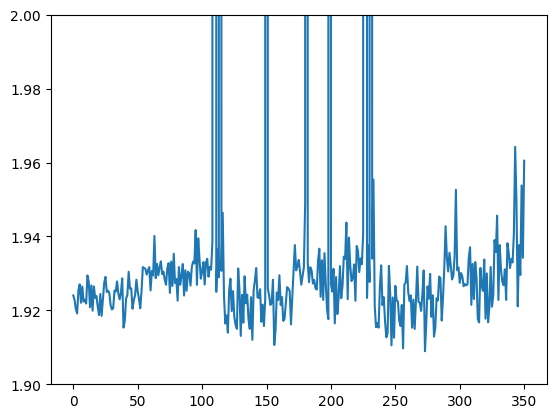

In [17]:
plt.plot(np.log(test_loss))
plt.ylim([1.9,2])